In [1]:
import numpy as np

# File path
file_path = "/data/home/huixian/Documents/Homeworks/535_project/post-fusion/audio_mlp_preds.npy"

# Load the .npy file
data = np.load(file_path)

# Display basic info
print("✅ File loaded successfully.")
print("Shape:", data.shape)
print("Data type:", type(data))
print("Sample content:\n", data[:5])  # Show the first 5 entries


✅ File loaded successfully.
Shape: (286,)
Data type: <class 'numpy.ndarray'>
Sample content:
 [0 1 2 1 0]


In [9]:
import pandas as pd
from collections import Counter

# Load input files
text_path = "/data/home/huixian/Documents/Homeworks/535_project/post-fusion/mlp_segment_predictions.csv"
merged_path = "/data/home/huixian/Documents/Homeworks/535_project/post-fusion/merged_preds.csv"

df_text = pd.read_csv(text_path)
df_merged = pd.read_csv(merged_path)

# Perform inner join to keep only mutually existing rows
df = pd.merge(df_text, df_merged, how="inner", left_on="segment_id", right_on="video_filename")

# Drop duplicates based on segment_id (keep first occurrence)
df = df.drop_duplicates(subset="segment_id")

# Ensure proper types
df["predicted_label"] = df["predicted_label"].astype(int)
df["video_sentiment_class"] = df["video_sentiment_class"].astype(int)
df["audio_label"] = df["audio_label"].astype(int)
df["audio_gt"] = df["audio_gt"].astype(int)

# Majority vote with tie-breaker = 1
def majority_vote(row):
    votes = [row["predicted_label"], row["video_sentiment_class"], row["audio_label"]]
    counter = Counter(votes)
    most_common = counter.most_common()
    max_count = most_common[0][1]
    tied_classes = [cls for cls, count in most_common if count == max_count]
    return tied_classes[0] if len(tied_classes) == 1 else (1 if 1 in tied_classes else tied_classes[0])

df["post_fusion"] = df.apply(majority_vote, axis=1)

# Select final columns
df_final = df[["segment_id", "predicted_label", "video_sentiment_class", "audio_label", "audio_gt", "post_fusion"]]

# Save result
df_final.to_csv("post_fusion_result.csv", index=False)
print(f"✅ Saved {len(df_final)} unique post-fusion predictions to 'post_fusion_result.csv'")


✅ Saved 142 unique post-fusion predictions to 'post_fusion_result.csv'



🔎 Accuracy: 0.4718

📊 Classification Report:

              precision    recall  f1-score   support

Negative (0)     0.4474    0.4359    0.4416        39
 Neutral (1)     0.4375    0.2800    0.3415        50
Positive (2)     0.5000    0.6792    0.5760        53

    accuracy                         0.4718       142
   macro avg     0.4616    0.4650    0.4530       142
weighted avg     0.4635    0.4718    0.4565       142

🔢 Confusion Matrix:
[[17  9 13]
 [13 14 23]
 [ 8  9 36]]


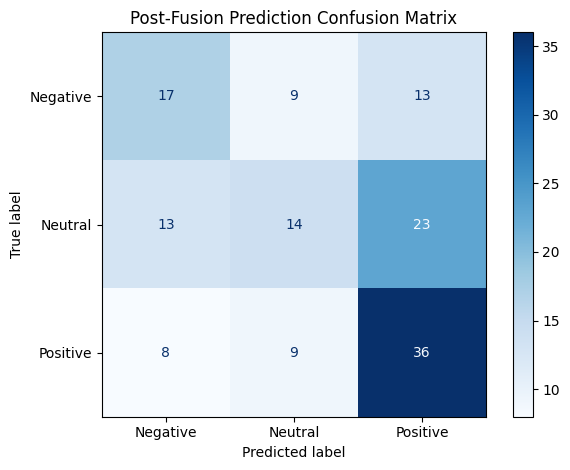

In [10]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Load the post-fusion result
df = pd.read_csv("post_fusion_result.csv")

# Ground truth and prediction
y_true = df["audio_gt"]
y_pred = df["post_fusion"]

# 1. Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n🔎 Accuracy: {accuracy:.4f}")

# 2. Classification report
target_names = ["Negative (0)", "Neutral (1)", "Positive (2)"]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("\n📊 Classification Report:\n")
print(report)

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("🔢 Confusion Matrix:")
print(cm)

# 4. Confusion matrix plot (optional)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Post-Fusion Prediction Confusion Matrix")
plt.tight_layout()
plt.show()
